#### final notebook on peak finding. insert notebook desc here

load libraries

In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.ioff()

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6


Get metadata

In [8]:
sample = gpd.read_parquet("../data/sample.parquet")
sample["eFUA_ID"] = sample["eFUA_ID"].astype(int)
citynames = dict(zip(sample["eFUA_ID"], sample["eFUA_name"]))
continents = dict(zip(sample["eFUA_ID"], sample["continent"]))
fuakeys = dict(zip(sample["eFUA_name"], sample["eFUA_ID"]))

Define plot parameters

In [9]:
sns.set_theme(context="paper", style="ticks", rc={'patch.force_edgecolor': False}, palette=Bold_6.hex_colors)
plt.rc("axes.spines", top=False, right=False)
coldict = dict(zip(np.unique(sample["continent"]), Bold_6.hex_colors))

Read in all functional urban area (FUA) data sets - each line in the data frame represents one graph face polygon 

In [10]:
def makefua_gdf(myfua):
    myfua = int(myfua)
    gdf = gpd.read_parquet(f"../data/{myfua}/polygons/")
    gdf["fua"] = myfua
    return (gdf)

apd = pd.concat([makefua_gdf(fua) for fua in sample.eFUA_ID])
apd = apd.reset_index(drop = True)

From list of all polygons, drop polygons with negative surface area

In [11]:
apd.drop(apd[apd["area"]<0].index, inplace = True)
apd = apd.reset_index(drop = True)

Define parameters for find_peak function

In [12]:
myh = None # required min height
myt = None # required min threshold
myd = 5 # required min dist between 2 peaks
myps = (0,10) # required min/max plateau size of peaks

Define threshold for maximum shape index value considered in the KDE

In [13]:
maxval = 150

For each of the FUAs,
1. get shape index values 
2. filter shape index values with maxval as maximum threshold
3. Fit a Gaussian kernel density estimation with Silverman bandwith estimation
4. Derive a disrete probability density destribution for linearly spaced values
5. Look for extrema (min/max) of the probability density destribution, with parameters defined above
6. If at least one peak has been found, extract its value 
6. Store peak data for FUA in `peakdict` subdictionary


In [14]:
peakdict = {}

for myfua in sample.eFUA_ID:
    
    peakdict[myfua] = {}   
    
    data = apd[apd["fua"]==myfua].shape_index.values
    data = data[data<=maxval]

    gk = gaussian_kde(data, bw_method= "silverman")
    s = np.linspace(-5, maxval+50, 1000)
    mypdf = gk.pdf(s)

    pmin = find_peaks(-mypdf, height = myh, threshold = myt, distance = myd, plateau_size = myps)

    if len(pmin[0]>0):
        mymins = []
        for i in pmin[0]:
            mymins.append(s[i])
    else:
        mymins = None

    pmax = find_peaks(mypdf, height = myh, threshold = myt, distance = myd, plateau_size = myps)

    if len(pmax[0]>0):
        mymaxs = []
        for i in pmax[0]:
            mymaxs.append(s[i])
    else:
        mymaxs = None

    peakdict[myfua]["city"] = citynames[myfua]
    peakdict[myfua]["continent"] = continents[myfua]
    peakdict[myfua]["maxnr"] = len(pmax[0])
    peakdict[myfua]["maxs"] = mymaxs
    peakdict[myfua]["minnr"] = len(pmin[0])
    peakdict[myfua]["mins"] = mymins
    peakdict[myfua]["pdf"] = mypdf


Convert dictinary to dataframe

In [15]:
peakdf = pd.DataFrame.from_dict(peakdict, orient = "index", columns = ["city", "continent", "maxnr", "maxs", "minnr", "mins"])

Get lists of unique peak numbers and continents

In [16]:
maxnrs = np.unique(peakdf["maxnr"])
minnrs = np.unique(peakdf["minnr"])
conts = np.unique(peakdf["continent"])

*******
Plot peak number distribution (colored by continent).

distribution of maxima:

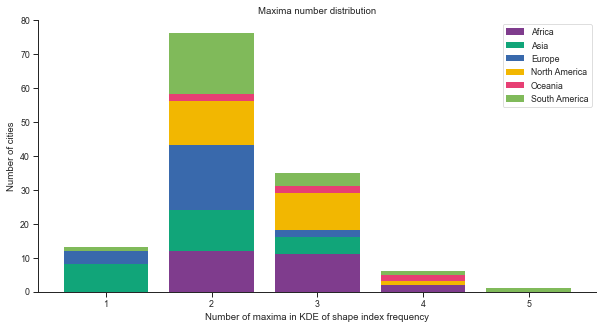

In [17]:
fig, ax = plt.subplots(1,1, figsize = (10,5))

for mypnr in maxnrs:

    myheights = [sum(peakdf[peakdf["maxnr"]==mypnr]["continent"] == mycont) for mycont in conts]
    mybottoms = [np.sum(myheights[0:i]) for i in range(len(myheights))]

    for i in range(len(conts)):
        b = ax.bar(
            x = mypnr,
            height = myheights[i],
            bottom = mybottoms[i],
            label = conts[i],
            color = coldict[conts[i]]
        )
        
h, l = ax.get_legend_handles_labels()
h = h[:6]
l = l[:6]
ax.legend(h, l)

ax.set_xlabel("Number of maxima in KDE of shape index frequency")
ax.set_ylabel("Number of cities")
ax.set_title("Maxima number distribution");
ax.set_ylim((0,80))

fig.savefig(f"../plots/stats/peakmaxima_distrib.png", 
    dpi = 400, transparent = False, facecolor = fig.get_facecolor(), bbox_inches = "tight")

distribution of minima:

In [18]:
# fig, ax = plt.subplots(1,1, figsize = (10,5), facecolor = "white")

# for mypnr in minnrs:

#     myheights = [sum(peakdf[peakdf["minnr"]==mypnr]["continent"] == mycont) for mycont in conts]
#     mybottoms = [np.sum(myheights[0:i]) for i in range(len(myheights))]

#     for i in range(len(conts)):
#         b = ax.bar(
#             x = mypnr,
#             height = myheights[i],
#             bottom = mybottoms[i],
#             label = conts[i],
#             color = coldict[conts[i]]
#         )
        
# h, l = ax.get_legend_handles_labels()
# h = h[:6]
# l = l[:6]
# ax.legend(h, l)

# ax.set_xlabel("Number of minima in KDE of shape index frequency")
# ax.set_ylabel("Number of cities")
# ax.set_title("Minima number distribution");
# ax.set_ylim((0,80))

# fig.savefig(f"../plots/stats/peakminima_distrib.png", 
#     dpi = 400, transparent = False, facecolor = fig.get_facecolor(), bbox_inches = "tight")

**************
Plot overview of 2+ maxima distributions by:
1. filtering the data for all maxima distributions with at least 2 peaks
2. extracting the values for peak 1 and peak 2
3. plotting the data sorting by ascending value of peak 1

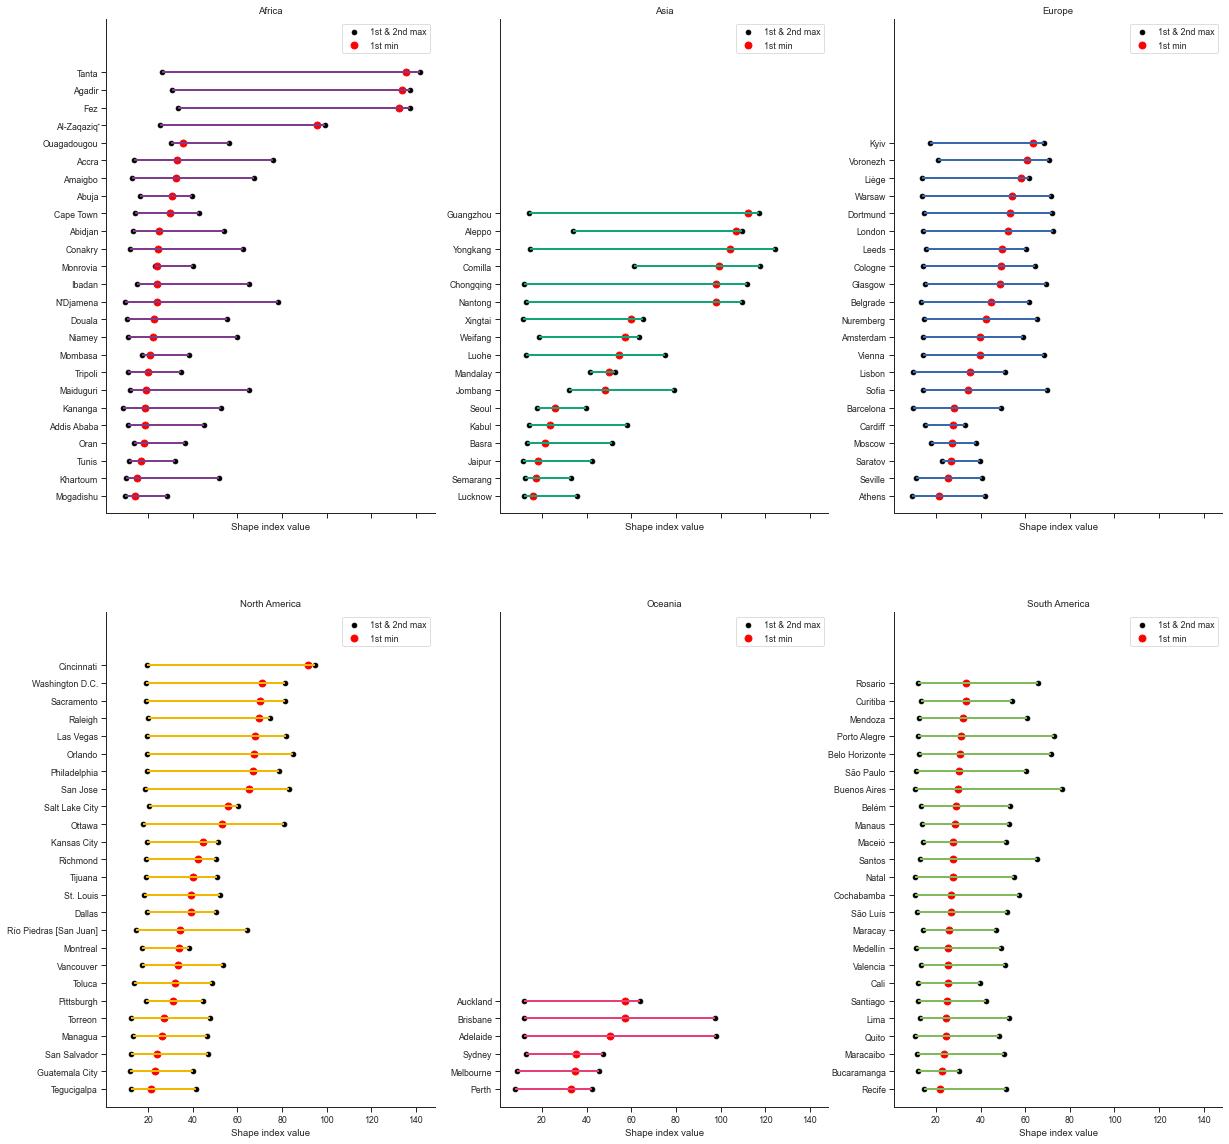

In [19]:
twopeaks = peakdf[peakdf["maxnr"]>=2].copy()

twopeaks["p1"] = twopeaks.apply(lambda x: x.maxs[0], axis = 1)
twopeaks["p2"] = twopeaks.apply(lambda x: x.maxs[1], axis = 1)
twopeaks["min1"] = twopeaks.apply(lambda x: x.mins[0], axis = 1)

fig, axs = plt.subplots(2,3, figsize = (20,20), sharex = True, sharey = False)

for cont, myax in zip(conts,fig.axes):
    vals = twopeaks[twopeaks["continent"]==cont][["p1", "p2", "min1"]].copy()
    vals = vals.sort_values(by = "min1").copy()
    myax.set_title(cont)
    myax.set_xlabel("Shape index value")
    myax.set_ylim((-1,27))
    for i, j in enumerate(vals.index):
        myax.hlines(y = i, xmin = vals.loc[j, "p1"], xmax = vals.loc[j, "p2"], linewidth = 2, color = coldict[cont])
        myax.scatter(y = [i, i], x = [vals.loc[j, "p1"], vals.loc[j, "p2"]], color = "black", label = "1st & 2nd max")
        myax.scatter(y = i, x = twopeaks.loc[j, "mins"][0], color = "red", s = 50, label = "1st min")
    
        h, l = myax.get_legend_handles_labels()
        h = h[:2]
        l = l[:2]
        myax.legend(h, l)

    myax.set_yticks([i for i in range(len(vals))], [citynames[j] for j in vals.index])


fig.savefig(f"../plots/stats/maxminmax_cont.png", 
    dpi = 400, transparent = False, facecolor = fig.get_facecolor(), bbox_inches = "tight")


*********
Plot and save shape index distributions and minima for each FUA

In [20]:
plt.rc("axes.spines", top=False, right=True)

for myfua in sample.eFUA_ID:

    fig, ax = plt.subplots(1,1,figsize=(10,5), facecolor = "white")

    # plot kde
    ax.plot(s, peakdict[myfua]["pdf"], label = "KDE", color = coldict[continents[myfua]], linewidth = 3)

    # plot minimum (if any)
    if peakdict[myfua]["mins"]:
        plt.axvline(
            x = peakdict[myfua]["mins"][0], 
            ymin = 0, 
            ymax = 1, 
            color = "red", 
            label = "first minimum",
            linestyle = "--")
        ax.set_title("KDE and 1st min for " + citynames[myfua])
    else:
        ax.set_title("KDE (no min) for " + citynames[myfua])

    # plot frequency histogram
    ax2=ax.twinx()
    apd[apd["fua"]==myfua].shape_index.plot.hist(
        ax = ax2, 
        figsize=(12, 10), 
        bins=2000, 
        alpha = 0.3,
        color = "grey",
        label = "shape index histogram")
    
    # global settings
    ax.set_xlabel("Shape index")
    ax.set_ylabel("Probability density")
    ax.set_xlim(-10,200)
    ax.set_ylim(0,peakdict[myfua]["pdf"].max()*1.1)
    ax2.legend(loc = "upper right");
    ax.legend(loc = "upper left");
    
    # save
    if peakdict[myfua]["mins"]:
        fig.savefig(f"../plots/kde/min/{myfua}.png", dpi = 400, transparent = False, facecolor = fig.get_facecolor(), bbox_inches = "tight")
    else: 
        fig.savefig(f"../plots/kde/nomin/{myfua}.png", dpi = 400, transparent = False, facecolor = fig.get_facecolor(), bbox_inches = "tight")

    plt.close()

*******
to visualize and explore, for a particular FUA:

In [20]:
myfua = fuakeys["Abuja"]
mymin = peakdict[myfua]["mins"][0]
polygons = gpd.read_parquet(f"../data/{myfua}/polygons/")
polygons.query(f"shape_index < {mymin}").explore(prefer_canvas=True)

/Users/anvy/opt/anaconda3/envs/OSMNX/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
